# Bathymetric Data Visualization
### Objective(s) for this notebook:
- Download a small tile from _WCS_ & attempt to make successive contours from it with a contour making function, which exports a list or set of contours in vector format
- Then, try to stich together _WCS_ tiles to create the entire Mediterranean raster
- Acquire, plot, and export contours for this stitch

In [1]:
# You can find more detail on these libraries by consulting my install script or
# visiting their page on CRAN.
library(XML)
library(ncdf4)
library(sp)
library(lattice)
library(terra)
library(downloader)
library(ggplot2)
library(directlabels)
library(rasterVis)
library(raster)
library(gdalUtilities)

terra 1.7.55



## Downloading a tile:

To give some perspective, the small area we intend to query here is $2.5$ by $2.5$ degrees and an arc minute is $\frac{1}{60}$ of a degree, so:

- At a resolution of 1/8 arc minute, there would be $8\times 60\times 2.5=1200$ samples across each axis, for a total of $1,440,000$ total samples
- At a resolution of 1/16 arc minute, there would be $24$ (twice as many) samples across each axis, for a total of $5,670,000$ total samples

In [2]:
# Set a bounding box for the Thermaic Gulf:
xmin <- 22.0
xmax <- 24.5
ymin <- 39.0
ymax <- 41.0

In [3]:
get_bathymetry_tile <- function(name, xmin, xmax, ymin, ymax, resx = 1, resy = 1) {
  bounding_box <- paste(xmin, ymin, xmax, ymax, sep = ",")
  url <- paste("https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=",
               name, "&crs=EPSG:4326&BBOX=", bounding_box,
               "&format=image/tiff&interpolation=nearest&resx=", resx, "&resy=", resy,
               sep = "")
  print(paste("Full Request URL:", url))
  temp <- paste(name, "img.tiff", sep = "_")
  temp <- tempfile(temp)
  download.file(url, temp, quiet = FALSE, mode = "wb")
  img_raw <- raster(temp)
  img_raw <- -1 * img_raw
  img_raw[img_raw < 0] <- 0 # (any heights above sea level become 0)
  img_raw[img_raw == 0] <- NaN # (any coastlines are marked with NaN)
  return(img_raw)
}

In [4]:
img <- get_bathymetry_tile(name="emodnet:mean", xmin, xmax, ymin, ymax, resx = 0.001, resy = 0.001)

[1] "Full Request URL: https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=emodnet:mean&crs=EPSG:4326&BBOX=22,39,24.5,41&format=image/tiff&interpolation=nearest&resx=0.001&resy=0.001"


In [5]:
bathy <- as.data.frame(as(img, "SpatialPixelsDataFrame"))

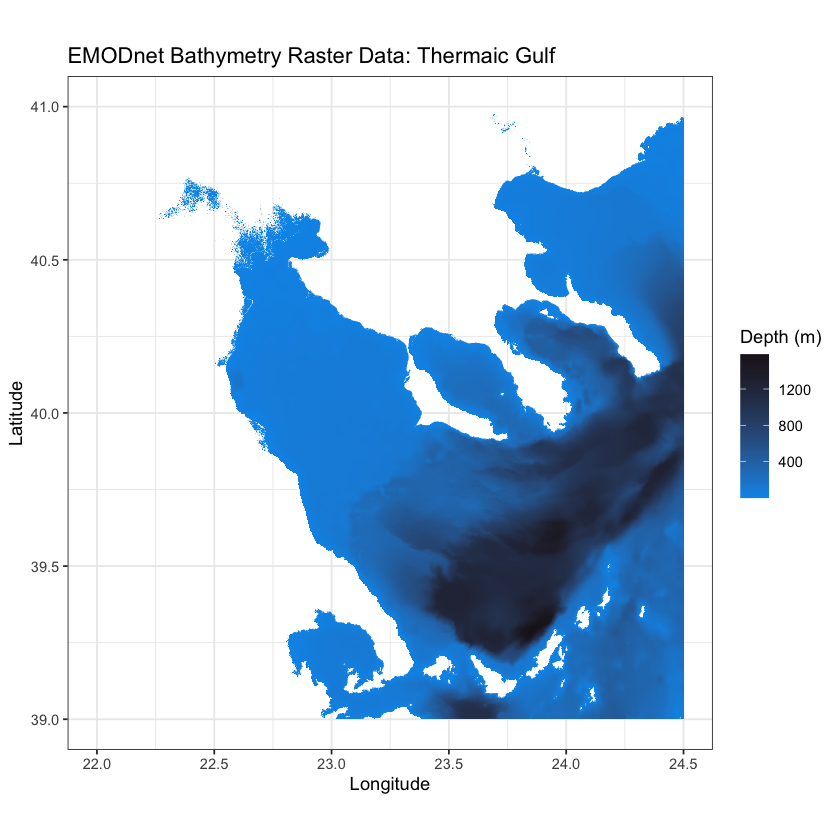

In [6]:
map <- ggplot(aes(x = x, y = y, z = emodnet.mean_img), data = bathy) +
  geom_tile(data = bathy, aes(fill = emodnet.mean_img)) +
  scale_fill_gradient(low = "#0097ea", high = "#1f1820", name = "Depth (m)") +
  coord_quickmap(xlim = range(xmin, xmax), ylim = range(ymin, ymax)) +
  ggtitle("EMODnet Bathymetry Raster Data: Thermaic Gulf") +
  xlab("Longitude") +
  ylab("Latitude") +
  theme_bw()
map

## Creating contours:

In [19]:
dim(img)

[1] 2000 2500    1

it appears as if the specification of `res = 0.001` $\implies$ that there are 1000 samples per degree (.001 degrees of coverage per sample).

In [8]:
tail(img)

,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
1991,23.42578,23.71094,22.80078,19.6796875,17.15234,15.3867188,15.85156,15.85156,18.21093750,20.539062,22.324219,25.101562,28.613281,29.83984,31.25781,34.77344,35.37500,40.90625,41.33594,44.23828
1992,21.51562,21.53125,20.07031,18.5117188,14.56641,13.8085938,12.83984,12.83984,16.23046875,16.058594,18.925781,23.925781,26.687500,28.54688,30.02344,32.62891,35.38672,35.21875,39.09766,43.59766
1993,19.90625,20.21875,19.29688,18.0546875,14.35156,10.8710938,11.72656,11.72656,6.15625000,13.082031,17.726562,21.417969,24.308594,27.31641,30.10156,29.36328,32.60156,36.13281,39.67188,43.05469
1994,17.87891,16.75781,19.69500,18.4549999,14.17000,9.7270002,10.55200,10.55200,NaN,8.121094,16.976562,20.035156,23.937500,26.44141,26.45312,28.28516,33.32031,34.67188,36.24219,38.21875
1995,16.90200,12.80900,13.45900,8.5290003,4.11300,NaN,NaN,NaN,12.35599995,14.688000,18.358999,19.039062,21.402344,22.67188,23.90625,26.54688,29.73438,29.14844,34.57422,37.34375
1996,16.11200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.065001,17.726562,15.812500,18.83203,20.96094,23.79688,25.89062,29.25781,30.61719,31.70312
1997,17.99200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.139999,13.714844,16.281250,17.06641,19.39844,22.71484,24.11328,26.01562,27.95312,31.05859
1998,17.33900,9.42600,NaN,NaN,NaN,NaN,NaN,NaN,0.07285595,NaN,NaN,4.968750,9.621094,13.67188,17.61328,17.47656,21.09766,24.70312,24.94922,28.02344
1999,13.55300,5.35700,2.33300,NaN,NaN,0.3317833,19.51100,19.51100,20.05999947,NaN,3.140625,8.351562,13.406250,15.12891,14.63281,18.75781,20.61328,22.34766,23.46094,26.51172
2000,16.45000,12.13700,5.32600,0.3650522,13.39800,17.7609997,18.93100,18.93100,19.60000038,10.105469,10.660156,10.375000,11.507812,18.11328,19.70312,22.44922,22.51172,25.03906,25.31250,30.92578


In [12]:
tail(bathy)

,emodnet.mean_img,x,y
,<dbl>,<dbl>,<dbl>
2385643,19.70312,24.4945,39.0005
2385644,22.44922,24.4955,39.0005
2385645,22.51172,24.4965,39.0005
2385646,25.03906,24.4975,39.0005
2385647,25.31250,24.4985,39.0005
2385648,30.92578,24.4995,39.0005


It looks like the data frame, structured `intensity, x, y` like `bathy` would be much easier to stitch together than a `RasterLayer` object that doesn't have easily-accessible coordinates.